In [1]:
%run ./sexism_data_preprocessing.ipynb

  0%|          | 483/400001 [00:00<01:22, 4824.98it/s]

0
tensor([[    8,     1,  1298,     8,  1298,   928,  1272,     1,  5071,     7],
        [   17,  1355,  1219,     1,   377,   863,  1836,  1987,     8,     7],
        [ 1987,   711,  1040,   711,   377,     1,     7,     1,   972,     8],
        [ 5071,  1987,     7,  1272,     1,     7,     1,   377,   711,     7],
        [ 1987,     7,  1298,     1,  1272,   863,     1,  1319,   711,   928],
        [    1,     8,     1,  1272,  1987,     8,   928,  2407,     1,  1272],
        [ 1836,     7,  1219,   711,     1,  1272,   863,   928,     1,  1298],
        [ 3598,   386,  1319,  2407,     1,     7,   928,  1298,     1,     7],
        [ 2743,   711,  1040,  1219,     1,   711,  1836,     8,  1319,     1],
        [  863,  1987,     1,   711,  1122,     1,  3605,   711,   711,   711],
        [ 1836,   972,   711,     7,   377,   711,     1,  1272,     7,  2407],
        [    8,     1,  1272,  1987,     8,   928,  2407,     1,  5071,   711],
        [    7,   928,   863,  1272,  

100%|██████████| 400001/400001 [01:24<00:00, 4748.32it/s]


_PAD
..
slut-shaming
ikhtiyaar
youve
.account
.weheal
shouldnt
leoratan.com
.x
//
-he
+male
womxn
2019.
y'all
ok.
stickers*
*selected
4.
sivememes
shayeris
blackwomanvibes
||
-she
dress-coded
w/
hadnt
twohey
werent
selfies
.model
gaslighting
.fsf
finna
f*ck
inktober
setelan
tshirt
2015.
hahaha
bernies
.s
feminisim
'not
wombyn
instagrams
jerah
sanuco
f***
weheal
tbh
evulving.com
lmao
.i
selfie
girlsonfilmde
alices
ejiro
.didit
trumpty
brexit
crysty
lifestye
'adolescents
catcalled
patreon
everyones
brown-long
tireport
1*
him-
.of.odisha
aubrie
1.6billion
immigrants/illegals
d.a.c.a
25billion
storycomment
'someone
non-binary
idk
nienke
theyll
emoji
.mcg
.france
.world
8.
simps
mooro
38bd
assault/harassment/rape
movingparts
2018.
tpif
mansplaining
*if
cashapp
comfortinthestorm
unfollow
matira
.rights.feminists
cyntoia
.makeup
9x12
harga
-60cm/23.62
-52cm/20.47
slut-shamed
*this
.official
is.1
heightaccording
1969the
female.2
strugglesfrom
oppressionthe
issuesfrom
bpps
.wearstyle
meesha
mal

everrrrr
omgegawwwdddd
yaaaaaaaaaa
overrrrrrrrrrrrrr
unhumanllyyyy
prolly
ps5
tooooo
*prays
*tsubasa
-hear
*good
years..
myrkky
harassment..
sex/sexual
infactuation
zakisha
faduma
owvs
keosha
amazzzzing
bjp/rss
sambit
goondas
sodomization
refferred
qwns
jerralyn
.so
house-bikini
hello.com
back/walk
watsup
7621960353
googal
a-being
*it*
pre-print
unknow
//um
cenarios
//ssbb//ebanx//circus
//show
case//battle
2v2
chalega
turnt
eventthankyou
partand
~~
sheminist
man-hater
kardete
outfits/actions/words
kumail
nanjiani
.ashz
pearrm
.pilgrim
saying/
forcehas
typification
help-filled
redemptively
tooo
25mtrs
ilupeju
bypass..
odun
07086251253
*time
*event
easyswimmingconcept
superioroptionsltd
bave
l'anne
dernire
dsole
n'oubliez
1965.
'fore
goshhhhh
funeral-home
taboos..
msinthebiz.com
19-25.
978-1999212209
=/
ad-
power/the
care.no
tangrystan
*************
**book
soul/self
chalenges
*see
esthers
example*
extrovertism
cherishable
magistery
age/older
.really
gaias
0.32amps
7986437124
included/
b

In [2]:
import numpy as np
import os
import random
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

## Model Arch

In [6]:
class LSTMSentenceEncoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,vectors,word2idx,cudaFlag,device):
        super(LSTMSentenceEncoder,self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vectors,freeze=False,padding_idx=word2idx['_PAD'])
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.word2idx = word2idx
        self.input_size = input_size
        self.cudaFlag = cudaFlag
        self.device = device
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):
        if self.cudaFlag:
            h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True).to(self.device)
            c0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True).to(self.device)
            
            embs = self.embedding(x)
            embs = embs.view(x.size(0),-1,self.input_size).requires_grad_().to(self.device)
            
        else:
            h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True)
            c0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True)
        
        embs = self.embedding(x)
        embs = embs.view(x.size(0),-1,self.input_size)

        out,(hn,cn) = self.lstm(embs,(h0,c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

In [7]:
wordEmbs = torch.tensor(vectors)

In [8]:
wordEmbs.size()

torch.Size([17789, 300])

### Model 1 - LSTM Sent Enc - with hidden dim size of 50

In [9]:
input_size = 300
hid_size = 50
output_size = 3
num_layers = 1

In [12]:
device = 'cuda:1'
cudaFlag = torch.cuda.is_available()
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available,device)
if torch.cuda.is_available():
    model = model.to(device)
model.float()

LSTMSentenceEncoder(
  (embedding): Embedding(17789, 300, padding_idx=0)
  (lstm): LSTM(300, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [14]:
model.forward(sentToTensor('this is a test',word2idx,vectors).to(device))

tensor([[-0.1705, -0.0346,  0.2067]], device='cuda:1', grad_fn=<AddmmBackward>)

In [16]:
count = 0
seq_dim = 10
num_epochs = 50

train_losses_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label) in enumerate(trainLoaderMC):
        if cudaFlag:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
            
        else:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
    
        optimizer.zero_grad()
        
        outputs = model(text)
#         print(outputs)
#         print(sexism_label)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            
            correct = 0
            total = 0
            
            allLabels = []
            allPreds = []
            
            for text,sexism_label in testLoaderMC:
                if cudaFlag:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))

                else:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))
                
                predicted = model(text)
                allLabels.append(sexism_label)
                allPreds.append(predicted)
                
                vloss = criterion(predicted,sexism_label)
                val_losses.append(vloss.data.cpu())
                
            train_losses_iterwise.append(np.mean(train_losses))
            val_losses_iterwise.append(np.mean(val_losses))
            
            allPreds = torch.cat(allPreds)
            allLabels = torch.cat(allLabels)
            
            print('Iteration: {}. Loss: {}. Val_loss: {}'.format(count, np.mean(train_losses), np.mean(val_losses)))
#             print(predicted)
#             print(labels)

  2%|▏         | 1/50 [00:00<00:14,  3.34it/s]

Iteration: 50. Loss: 0.32720404863357544. Val_loss: 0.3259139657020569


  6%|▌         | 3/50 [00:00<00:15,  3.08it/s]

Iteration: 100. Loss: 0.30759817361831665. Val_loss: 0.3259825110435486


  8%|▊         | 4/50 [00:01<00:15,  3.03it/s]

Iteration: 150. Loss: 0.3046691119670868. Val_loss: 0.3282497227191925


 10%|█         | 5/50 [00:01<00:15,  2.99it/s]

Iteration: 200. Loss: 0.298967570066452. Val_loss: 0.33620500564575195


 12%|█▏        | 6/50 [00:02<00:14,  2.96it/s]

Iteration: 250. Loss: 0.30032119154930115. Val_loss: 0.3319176137447357


 14%|█▍        | 7/50 [00:02<00:14,  3.07it/s]

Iteration: 300. Loss: 0.3358013331890106. Val_loss: 0.33771735429763794


 16%|█▌        | 8/50 [00:02<00:13,  3.01it/s]

Iteration: 350. Loss: 0.3018026649951935. Val_loss: 0.34004002809524536


 20%|██        | 10/50 [00:03<00:13,  2.93it/s]

Iteration: 400. Loss: 0.29969069361686707. Val_loss: 0.3469397723674774


 22%|██▏       | 11/50 [00:03<00:13,  2.93it/s]

Iteration: 450. Loss: 0.28755152225494385. Val_loss: 0.34077030420303345


 24%|██▍       | 12/50 [00:04<00:12,  2.93it/s]

Iteration: 500. Loss: 0.3059329688549042. Val_loss: 0.3347632884979248


 26%|██▌       | 13/50 [00:04<00:12,  3.06it/s]

Iteration: 550. Loss: 0.36974096298217773. Val_loss: 0.344234436750412


 28%|██▊       | 14/50 [00:04<00:11,  3.02it/s]

Iteration: 600. Loss: 0.30229803919792175. Val_loss: 0.3371523320674896


 32%|███▏      | 16/50 [00:05<00:11,  2.96it/s]

Iteration: 650. Loss: 0.30070704221725464. Val_loss: 0.3374374210834503


 34%|███▍      | 17/50 [00:05<00:11,  2.94it/s]

Iteration: 700. Loss: 0.3043331503868103. Val_loss: 0.3419692814350128


 36%|███▌      | 18/50 [00:06<00:10,  2.93it/s]

Iteration: 750. Loss: 0.30279791355133057. Val_loss: 0.34223538637161255


 38%|███▊      | 19/50 [00:06<00:10,  3.05it/s]

Iteration: 800. Loss: 0.33307158946990967. Val_loss: 0.3507519066333771


 40%|████      | 20/50 [00:06<00:10,  3.00it/s]

Iteration: 850. Loss: 0.2863519787788391. Val_loss: 0.3397063612937927


 44%|████▍     | 22/50 [00:07<00:09,  2.93it/s]

Iteration: 900. Loss: 0.26847633719444275. Val_loss: 0.3404015004634857


 46%|████▌     | 23/50 [00:07<00:09,  2.93it/s]

Iteration: 950. Loss: 0.2837069034576416. Val_loss: 0.33989837765693665


 48%|████▊     | 24/50 [00:08<00:08,  2.93it/s]

Iteration: 1000. Loss: 0.29186248779296875. Val_loss: 0.3457317352294922


 50%|█████     | 25/50 [00:08<00:08,  2.94it/s]

Iteration: 1050. Loss: 0.28958451747894287. Val_loss: 0.3477465510368347


 52%|█████▏    | 26/50 [00:08<00:07,  3.07it/s]

Iteration: 1100. Loss: 0.2915177345275879. Val_loss: 0.3422207832336426


 56%|█████▌    | 28/50 [00:09<00:07,  2.97it/s]

Iteration: 1150. Loss: 0.269450843334198. Val_loss: 0.348194420337677


 58%|█████▊    | 29/50 [00:09<00:07,  2.94it/s]

Iteration: 1200. Loss: 0.2819547951221466. Val_loss: 0.35314130783081055


 60%|██████    | 30/50 [00:10<00:06,  2.92it/s]

Iteration: 1250. Loss: 0.28706932067871094. Val_loss: 0.3432369530200958


 62%|██████▏   | 31/50 [00:10<00:06,  2.92it/s]

Iteration: 1300. Loss: 0.2895408868789673. Val_loss: 0.3465287983417511


 64%|██████▍   | 32/50 [00:10<00:05,  3.04it/s]

Iteration: 1350. Loss: 0.2526112496852875. Val_loss: 0.3438367545604706


 66%|██████▌   | 33/50 [00:11<00:05,  2.98it/s]

Iteration: 1400. Loss: 0.27438536286354065. Val_loss: 0.3481389880180359


 70%|███████   | 35/50 [00:11<00:05,  2.93it/s]

Iteration: 1450. Loss: 0.25091618299484253. Val_loss: 0.3394117057323456


 72%|███████▏  | 36/50 [00:12<00:04,  2.91it/s]

Iteration: 1500. Loss: 0.27656540274620056. Val_loss: 0.3421514630317688


 74%|███████▍  | 37/50 [00:12<00:04,  2.91it/s]

Iteration: 1550. Loss: 0.2872869372367859. Val_loss: 0.3397237956523895


 76%|███████▌  | 38/50 [00:12<00:03,  3.04it/s]

Iteration: 1600. Loss: 0.31492310762405396. Val_loss: 0.34339070320129395


 78%|███████▊  | 39/50 [00:13<00:03,  2.99it/s]

Iteration: 1650. Loss: 0.28671854734420776. Val_loss: 0.34563422203063965


 82%|████████▏ | 41/50 [00:13<00:03,  2.93it/s]

Iteration: 1700. Loss: 0.2898513674736023. Val_loss: 0.3392236530780792


 84%|████████▍ | 42/50 [00:14<00:02,  2.91it/s]

Iteration: 1750. Loss: 0.2857491970062256. Val_loss: 0.3438208997249603


 86%|████████▌ | 43/50 [00:14<00:02,  2.92it/s]

Iteration: 1800. Loss: 0.2780020236968994. Val_loss: 0.3464968800544739


 88%|████████▊ | 44/50 [00:14<00:01,  3.05it/s]

Iteration: 1850. Loss: 0.23169520497322083. Val_loss: 0.3392978012561798


 90%|█████████ | 45/50 [00:15<00:01,  3.00it/s]

Iteration: 1900. Loss: 0.23492717742919922. Val_loss: 0.3485468924045563


 94%|█████████▍| 47/50 [00:15<00:01,  2.94it/s]

Iteration: 1950. Loss: 0.3001942038536072. Val_loss: 0.34625837206840515


 96%|█████████▌| 48/50 [00:16<00:00,  2.92it/s]

Iteration: 2000. Loss: 0.2625965476036072. Val_loss: 0.3480716347694397


 98%|█████████▊| 49/50 [00:16<00:00,  2.91it/s]

Iteration: 2050. Loss: 0.27064964175224304. Val_loss: 0.3465883135795593


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

Iteration: 2100. Loss: 0.2735932767391205. Val_loss: 0.35698649287223816


In [17]:
iterNums = [i for i in range(len(train_losses_iterwise))]

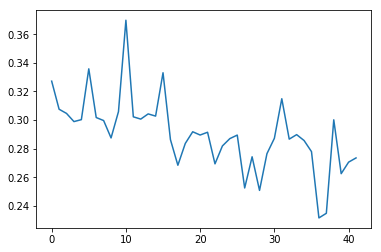

In [18]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])

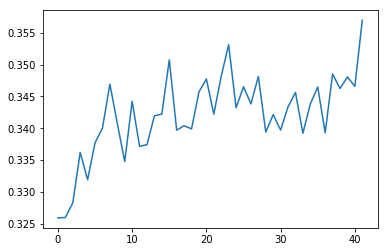

In [19]:
sns.lineplot(iterNums,[i.item() for i in val_losses_iterwise])

### Model 2 - LSTM Sent Enc - with hidden dim size of 100

In [20]:
input_size = 300
hid_size = 100
output_size = 2
num_layers = 1

In [34]:
device = 'cuda:1'
cudaFlag = torch.cuda.is_available()
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available,device)
if torch.cuda.is_available():
    model = model.to(device)
model.float()

RuntimeError: CUDA error: device-side assert triggered

In [22]:
count = 0
seq_dim = 10
num_epochs = 50

train_losses_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label) in enumerate(trainLoaderMC):
        if cudaFlag:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
            
        else:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
    
        optimizer.zero_grad()
        
        outputs = model(text)
#         print(outputs)
#         print(sexism_label)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            
            correct = 0
            total = 0
            
            allLabels = []
            allPreds = []
            
            for text,sexism_label in testLoaderMC:
                if cudaFlag:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))

                else:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))
                
                predicted = model(text)
                allLabels.append(sexism_label)
                allPreds.append(predicted)
                
                vloss = criterion(predicted,sexism_label)
                val_losses.append(vloss.data.cpu())
                
            train_losses_iterwise.append(np.mean(train_losses))
            val_losses_iterwise.append(np.mean(val_losses))
            
            allPreds = torch.cat(allPreds)
            allLabels = torch.cat(allLabels)
            
            print('Iteration: {}. Loss: {}. Val_loss: {}'.format(count, np.mean(train_losses), np.mean(val_losses)))
#             print(predicted)
#             print(labels)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

In [25]:
iterNums = [i for i in range(len(train_losses_iterwise))]

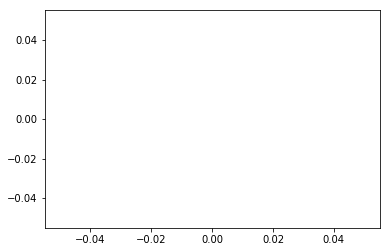

In [26]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])

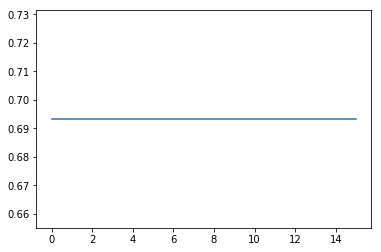

In [71]:
sns.lineplot(iterNums,[i.item() for i in val_losses_iterwise])

### Model 3 - LSTM Sent Enc - with hidden dim size of 100 and 2 Layers

In [73]:
input_size = 300
hid_size = 100
output_size = 2
num_layers = 2

In [74]:
device = 'cuda:1'
cudaFlag = torch.cuda.is_available()
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available,device)
if torch.cuda.is_available():
    model = model.to(device)
model.float()

LSTMSentenceEncoder(
  (embedding): Embedding(17870, 300, padding_idx=0)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [75]:
count = 0
seq_dim = 10
num_epochs = 20

train_losses_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label, sexism_type) in enumerate(trainLoader):
        if cudaFlag:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
            sexism_type = Variable(sexism_type.to(device))
            
        else:
            text = Variable(text.view(-1, seq_dim, 1).to(device))
            sexism_label = Variable(sexism_label.to(device))
            sexism_type = Variable(sexism_type.to(device))
    
        optimizer.zero_grad()
        
        outputs = model(text)
#         print(outputs)
#         print(sexism_label)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            
            correct = 0
            total = 0
            
            allLabels = []
            allPreds = []
            
            for text,sexism_label, sexism_type in testLoader:
                if cudaFlag:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))
                    sexism_type = Variable(sexism_type.to(device))

                else:
                    text = Variable(text.view(-1, seq_dim, 1).to(device))
                    sexism_label = Variable(sexism_label.to(device))
                    sexism_type = Variable(sexism_type.to(device))
                
                predicted = model(text)
                allLabels.append(sexism_label)
                allPreds.append(predicted)
                
                vloss = criterion(predicted,sexism_label)
                val_losses.append(vloss.data.cpu())
                
            train_losses_iterwise.append(np.mean(train_losses))
            val_losses_iterwise.append(np.mean(val_losses))
            
            allPreds = torch.cat(allPreds)
            allLabels = torch.cat(allLabels)
            
            print('Iteration: {}. Loss: {}. Val_loss: {}'.format(count, np.mean(train_losses), np.mean(val_losses)))
#             print(predicted)
#             print(labels)

  5%|▌         | 1/20 [00:00<00:06,  2.78it/s]

Iteration: 50. Loss: 0.7127541899681091. Val_loss: 0.7119636535644531


 15%|█▌        | 3/20 [00:01<00:06,  2.71it/s]

Iteration: 100. Loss: 0.7128658294677734. Val_loss: 0.7119636535644531


 20%|██        | 4/20 [00:01<00:05,  2.73it/s]

Iteration: 150. Loss: 0.7125938534736633. Val_loss: 0.7119636535644531


 25%|██▌       | 5/20 [00:01<00:05,  2.74it/s]

Iteration: 200. Loss: 0.7126290202140808. Val_loss: 0.7119636535644531


 30%|███       | 6/20 [00:02<00:05,  2.75it/s]

Iteration: 250. Loss: 0.7127114534378052. Val_loss: 0.7119636535644531


 35%|███▌      | 7/20 [00:02<00:04,  2.88it/s]

Iteration: 300. Loss: 0.7123618721961975. Val_loss: 0.7119636535644531


 40%|████      | 8/20 [00:02<00:04,  2.74it/s]

Iteration: 350. Loss: 0.7129520177841187. Val_loss: 0.7119636535644531


 50%|█████     | 10/20 [00:03<00:03,  2.74it/s]

Iteration: 400. Loss: 0.7125319838523865. Val_loss: 0.7119636535644531


 55%|█████▌    | 11/20 [00:04<00:03,  2.73it/s]

Iteration: 450. Loss: 0.7128360271453857. Val_loss: 0.7119636535644531


 60%|██████    | 12/20 [00:04<00:02,  2.68it/s]

Iteration: 500. Loss: 0.7127050161361694. Val_loss: 0.7119636535644531


 65%|██████▌   | 13/20 [00:04<00:02,  2.81it/s]

Iteration: 550. Loss: 0.7131712436676025. Val_loss: 0.7119636535644531


 70%|███████   | 14/20 [00:05<00:02,  2.77it/s]

Iteration: 600. Loss: 0.7123585343360901. Val_loss: 0.7119636535644531


 80%|████████  | 16/20 [00:05<00:01,  2.67it/s]

Iteration: 650. Loss: 0.7124274969100952. Val_loss: 0.7119636535644531


 85%|████████▌ | 17/20 [00:06<00:01,  2.62it/s]

Iteration: 700. Loss: 0.7125300765037537. Val_loss: 0.7119636535644531


 90%|█████████ | 18/20 [00:06<00:00,  2.64it/s]

Iteration: 750. Loss: 0.7127038240432739. Val_loss: 0.7119636535644531


 95%|█████████▌| 19/20 [00:06<00:00,  2.75it/s]

Iteration: 800. Loss: 0.7130578756332397. Val_loss: 0.7119636535644531


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


In [76]:
iterNums = [i for i in range(len(train_losses_iterwise))]

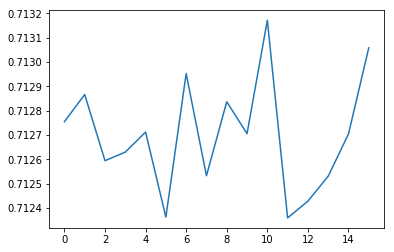

In [77]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])

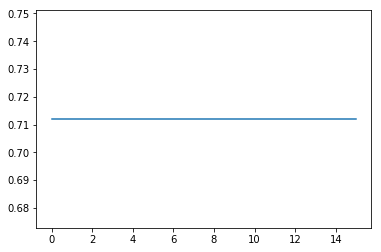

In [78]:
sns.lineplot(iterNums,[i.item() for i in val_losses_iterwise])